In [1]:
import os
import gc
import numpy as np
import tensorflow as tf
from Bio import SeqIO
from utils import preprocessing as pre
from sklearn.model_selection import train_test_split
import models
import pydot
import matplotlib.pyplot as plt
import importlib

In [2]:
gc.collect()
path = '../Data_Sets/PDB/FASTA'
file_name_m = 'mask_3.fasta'
file_name_t = 'mask_torsion.fasta'
dict_ = {'id':[] ,'mask':[],'seq':[], 'mask_bin':[], 'seq_bin':[], 'loss_weight':[], 'seq_int':[], 'coord':[], 'angle':[]}
count = 0
seq_length = 1024
d = {'H':1/0.372, 'B':1/0.2105, 'C':1/0.4173}
for i, rec in enumerate(SeqIO.parse(os.path.join(path,file_name_m),'fasta')):
    
    if i >5000:
        break
    if len(rec.seq)>seq_length:
        continue
        
    #print(rec.id)
    dict_['id'].append(rec.id)
    dict_['seq'].append(rec.seq)
    dict_['seq_int'].append(pre.to_int(rec.seq, max_length=seq_length))
    
    
    
    dict_['mask'].append(rec.description.split('|lcl|')[:len(rec.seq)])
    dict_['mask_bin'].append(pre.to_binary_mask(pre.mask_padding(rec.description.split('|lcl|')[-1], length=seq_length)))
    dict_['loss_weight'].append(pre.loss_weight(rec.description.split('|lcl|')[-1][:len(rec.seq)], d,seq_length))

    
for k, rec in enumerate(SeqIO.parse(os.path.join(path,file_name_t),'fasta')):
        
    if k >5000:
        break
    if len(rec.seq)>seq_length:
        continue
    #print(rec.id)


    f = np.array([ j.split(',')[1:] for j in rec.description.split('|lcl|')[-1].split(';')][1:], dtype=np.float32)
    f = ((360+f)%360)/180 * np.pi - np.pi
    dict_['angle'].append(pre.zero_padding(f,length=seq_length))

        

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(dict_['seq_int'], dtype = np.int8 ), np.array(dict_['angle'], dtype = np.float32), test_size=0.1, random_state=42)
id_train, id_test, seq_train, seq_test = train_test_split(dict_['id'], dict_['seq'], test_size=0.1, random_state=42)
W_train, W_test, M_train, M_test = train_test_split(dict_['loss_weight'], dict_['mask_bin'], test_size=0.1, random_state=42)

In [4]:
Y_test[0,:10,:]

array([[-3.1415927 , -0.06806827],
       [ 0.8237953 , -2.1170843 ],
       [ 1.9041545 ,  2.820452  ],
       [ 1.839577  ,  2.6040318 ],
       [ 2.1642082 ,  2.5342185 ],
       [ 2.0420353 ,  2.490585  ],
       [ 1.727876  , -0.32812166],
       [ 1.907645  ,  2.9024823 ],
       [ 2.2916172 ,  2.3998277 ],
       [ 2.0036376 ,  2.6755893 ]], dtype=float32)

In [20]:
gc.collect()

8012

In [ ]:
p1 = {'max_seq_len': seq_length,
     'num_classes': 3,
     'emb_size': 20,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[4, 4, 4, 4, 4] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.2, 0.2, 0.2, 0.2, 0.2],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.01, 0.01, 0.01, 0.01, 0.01],
     'use_max_pool': False,
     'learning_rate': 1e-4,
    'output_activation': 'softmax'}
p2 = {'max_seq_len': seq_length,
     'num_classes': 32,
     'emb_size': 10,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[4, 4, 4, 4, 4] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.2, 0.2, 0.2, 0.2, 0.2],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.01, 0.01, 0.01, 0.01, 0.01],
     'use_max_pool': False,
     'learning_rate': 1e-4,
    'output_activation': 'softmax',
     'features':32}


class TorsionLoss(tf.keras.losses.Loss):
    def __init__(self, size):
        super(TorsionLoss,self).__init__()
        self.size = size
        self.flatten = tf.keras.layers.Flatten()  
    
    def call(self, y_true, y_pred):

        y_true = tf.transpose(y_true, perm=[0,2,1])
        y_pred = tf.transpose(y_pred, perm=[0,2,1])
        

        y_true_csum = tf.keras.backend.cumsum(y_true, axis=-1)
        y_pred_csum = tf.keras.backend.cumsum(y_pred, axis=-1)

        
        y_true_mat_0 = tf.keras.backend.repeat(y_true_csum[:,0,:], self.size)
        y_true_mat_1 = tf.keras.backend.repeat(y_true_csum[:,1,:], self.size)
        y_pred_mat_0 = tf.keras.backend.repeat(y_pred_csum[:,0,:], self.size)
        y_pred_mat_1 = tf.keras.backend.repeat(y_pred_csum[:,1,:], self.size)
        

        y_pred_mat_0 = tf.transpose(y_pred_mat_0, perm=[0,2,1])
        y_pred_mat_1 = tf.transpose(y_pred_mat_1, perm=[0,2,1])

        vec_0 = tf.math.squared_difference(y_true_mat_0,y_pred_mat_0)
        vec_1 = tf.math.squared_difference(y_true_mat_1,y_pred_mat_1)
        
        dist_mat = tf.math.sqrt(tf.math.add(vec_0, vec_1))
        loss = tf.math.reduce_sum(tf.math.l2_normalize(dist_mat),axis=-1)
        return loss

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model1 = models.res_u_net(p1)
    model2 = models.res_u_net_tor(p2)


    model1.load_weights('Weights_MaskModel/w_LDataset')

    inp1 = tf.keras.layers.Input(shape=(seq_length))
    out1, x_o = model1(inp1)
    x1 = tf.keras.layers.Conv1D(32, 7, padding='same')(out1)
    x2 = tf.keras.layers.Conv1D(32, 7, padding='same')(x_o)
    inp2 = tf.keras.layers.Add()([x1,x2])
    out2 = model2(inp2)


    model = tf.keras.Model(inputs = inp1, outputs = [out1,out2])

    mse = tf.keras.losses.MeanSquaredError()
    loss = TorsionLoss(size=1024)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    add = tf.keras.optimizers.Adam(learning_rate=1e-4,name='Adam_1')



    model.load_weights('Weights_MaskModel/w_tor_mod')
    # compiling and fitting with Adam optimizer
    model.compile(optimizer = add, loss = [cce, loss], sample_weight_mode="temporal")
    his = []
    li1 = []

    for u in range(10):
        his.append(model.fit(X_train, [M_train, Y_train], batch_size=128,
                             epochs= 100, validation_split=0.1,
                             sample_weight = [ np.array(W_train),np.array(W_train)]))

        model.save_weights('Weights_MaskModel/w_tor_mod')
    #li1.append(model.evaluate(x = X_test, y = [M_test,Y_test], batch_size=64, verbose=0))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

Epoch 28/100
196422/196422 [==============================] - 466s 2ms/sample - loss: 0.8786 - model_loss: 0.5543 - model_1_loss: 0.0543 - val_loss: 0.9523 - val_model_loss: 0.7534 - val_model_1_loss: 0.0382
Epoch 29/100
196422/196422 [==============================] - 464s 2ms/sample - loss: 0.8966 - model_loss: 0.5546 - model_1_loss: 0.0431 - val_loss: 0.9389 - val_model_loss: 0.7534 - val_model_1_loss: 0.0125
Epoch 30/100
196422/196422 [==============================] - 463s 2ms/sample - loss: 0.8818 - model_loss: 0.5541 - model_1_loss: 0.0438 - val_loss: 0.8027 - val_model_loss: 0.6101 - val_model_1_loss: 0.0230
Epoch 31/100
196422/196422 [==============================] - 464s 2ms/sample - loss: 0.9077 - model_loss: 0.5544 - model_1_loss: 0.0475 - val_loss: 0.8782 - val_model_loss: 0.7456 - val_model_1_loss: 0.0125
Epoch 32/100
196422/196422 [==============================] - 467s 2ms/sample - loss: 0.8841 - model_loss: 0.5540 - model_1_loss: 0.0471 - val_loss: 0.7756 - val_model_

196422/196422 [==============================] - 464s 2ms/sample - loss: 0.9397 - model_loss: 0.5538 - model_1_loss: 0.0471 - val_loss: 1.0228 - val_model_loss: 0.7479 - val_model_1_loss: 0.0230
Epoch 68/100
196422/196422 [==============================] - 460s 2ms/sample - loss: 0.9422 - model_loss: 0.5540 - model_1_loss: 0.0486 - val_loss: 1.4324 - val_model_loss: 0.7641 - val_model_1_loss: 0.0906
Epoch 69/100
196422/196422 [==============================] - 463s 2ms/sample - loss: 0.8109 - model_loss: 0.5534 - model_1_loss: 0.0487 - val_loss: 0.8125 - val_model_loss: 0.7474 - val_model_1_loss: 0.0382
Epoch 70/100
196422/196422 [==============================] - 466s 2ms/sample - loss: 0.8659 - model_loss: 0.5531 - model_1_loss: 0.0513 - val_loss: 0.9962 - val_model_loss: 0.7528 - val_model_1_loss: 0.0312
Epoch 71/100
196422/196422 [==============================] - 466s 2ms/sample - loss: 0.9103 - model_loss: 0.5533 - model_1_loss: 0.0480 - val_loss: 1.0600 - val_model_loss: 0.7704 

In [5]:
model.save_weights('Weights_MaskModel/w_tor_mod')

In [6]:
with strategy.scope():
    model.load_weights('Weights_MaskModel/w_tor_mod')

IndexError: list index out of range

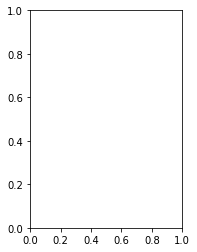

In [9]:
ax1 = plt.subplot(1,2,1)
ax1.plot(his[1].history['loss'])
ax1.plot(his[1].history['val_loss'])
ax2 = plt.subplot(1,2,2)
ax2.plot(his[0].history['val_model_1_loss'])
ax2.set_ylim([0,1])
plt.show()
#ax2.plot(his.history['val_accuracy'])

In [2]:
class TorsionLoss(tf.keras.losses.Loss):
    def __init__(self, size):
        super(TorsionLoss,self).__init__()
        self.size = size
         
    
    def call(self, y_true, y_pred):
        y_true = tf.transpose(y_true, perm=[0,2,1])
        y_pred = tf.transpose(y_pred, perm=[0,2,1])
        
        print(y_true)
        y_true_csum = tf.keras.backend.cumsum(y_true, axis=-1)
        y_pred_csum = tf.keras.backend.cumsum(y_pred, axis=-1)
        print(y_true_csum)
        
        y_true_mat_0 = tf.keras.backend.repeat(y_true[:,0,:], self.size)
        y_true_mat_1 = tf.keras.backend.repeat(y_true[:,1,:], self.size)
        y_pred_mat_0 = tf.keras.backend.repeat(y_pred[:,0,:], self.size)
        y_pred_mat_1 = tf.keras.backend.repeat(y_pred[:,1,:], self.size)
        

        y_pred_mat_0 = tf.transpose(y_pred_mat_0, perm=[0,2,1])
        y_pred_mat_1 = tf.transpose(y_pred_mat_1, perm=[0,2,1])

        vec_0 = tf.math.squared_difference(y_true_mat_0,y_pred_mat_0)
        vec_1 = tf.math.squared_difference(y_true_mat_1,y_pred_mat_1)
        
        dist_mat = tf.math.add(vec_0, vec_1)
        loss = tf.math.reduce_sum(tf.math.l2_normalize(dist_mat),axis=-1)
        return loss
    
pred = tf.reshape(tf.constant([[[1.0,2.1],[1.1, 1.7], [1.1, 1.2]],
                               [[1.0,2.1],[1.1, 1.7],[1.1, 1.2]]]),shape=(-1,3,2))
true = tf.reshape(tf.constant([[[1.1,2.2],[1.0, 1.8], [1.1,1.2]],
                               [[1.1,2.0],[1.2, 1.6],[1.1,1.2]]]),shape=(-1,3,2))

loss = TorsionLoss(size=3)

l = loss(true,pred)
print(l)

tf.Tensor(
[[[1.1 1.  1.1]
  [2.2 1.8 1.2]]

 [[1.1 1.2 1.1]
  [2.  1.6 1.2]]], shape=(2, 2, 3), dtype=float32)
tf.Tensor(
[[[1.1       2.1       3.1999998]
  [2.2       4.        5.2      ]]

 [[1.1       2.3000002 3.4      ]
  [2.        3.6       4.8      ]]], shape=(2, 2, 3), dtype=float32)
tf.Tensor(0.47631392, shape=(), dtype=float32)


In [6]:

M_pred, T_pred = model.predict(X_test)


In [22]:
print(Y_test[1,0:20,:])

[[-3.1415927  -0.97389364]
 [ 1.6109388  -1.1711161 ]
 [ 1.0611603  -0.47298384]
 [ 0.630064   -0.6719518 ]
 [ 0.3193953  -0.55152416]
 [ 0.5061455  -0.46774817]
 [ 0.54454255 -1.0035644 ]
 [ 1.0978119  -1.3020159 ]
 [ 1.7191494   2.9146998 ]
 [ 0.33510327 -0.4066615 ]
 [ 1.3124878  -0.7103493 ]
 [ 1.0681417  -0.9093168 ]
 [ 2.071706   -0.7679448 ]
 [-1.5184366   2.988004  ]
 [ 2.0856688  -1.1117749 ]
 [ 1.8046706  -3.0909784 ]
 [ 1.6493361   2.9391348 ]
 [ 1.0594151  -0.741765  ]
 [ 1.261873   -1.1309733 ]
 [ 1.5236723  -0.741765  ]]


In [9]:
print(T_pred[1,:20,:])

[[ 3.0118482 -2.8887055]
 [ 2.8379316 -2.970409 ]
 [ 2.8330193 -2.9651833]
 [ 2.8345227 -2.9657543]
 [ 2.83768   -2.9693463]
 [ 2.8380501 -2.970258 ]
 [ 2.8330176 -2.9652362]
 [ 2.8205764 -2.9512446]
 [ 2.798531  -2.923216 ]
 [ 2.7660465 -2.8726504]
 [ 2.7250214 -2.785374 ]
 [ 2.681994  -2.6457877]
 [ 2.6486592 -2.476455 ]
 [ 2.6365578 -2.3885598]
 [ 2.6489508 -2.4599097]
 [ 2.6781912 -2.6067867]
 [ 2.711286  -2.7290199]
 [ 2.7382298 -2.8045528]
 [ 2.7559404 -2.845935 ]
 [ 2.7664514 -2.8673937]]


In [4]:
import time
from utils import layers
importlib.reload(layers)
batch_size = 2
id_ = id_test[0]
with tf.device('/cpu:0'):
    coord = layers.CoordinalizationCell(batch_size)
    layer = tf.keras.layers.RNN(coord, return_sequences=True)

    st_1 = tf.constant([[1,-2,0.88] for _ in range(batch_size)])
    st_2 = tf.constant([[1,-1.45,0] for _ in range(batch_size)])
    st_3 = tf.constant([[1.0,0.0,0.0] for _ in range(batch_size)])


    start = time.process_time()
    o = layer(Y_test[:batch_size,:300,:], initial_state=[st_1,st_2,st_3])
    print(time.process_time()-start)

2.277838344000001


In [20]:
len(seq_test[1])

242

### print(T_pred[0,:10,:])

In [5]:
print(o[1,:10,:])

tf.Tensor(
[[-4.3281507e-01  8.8572669e-08 -3.5877639e-01 -4.1480124e-02
   4.0720081e-01  3.4816438e-01  3.4425700e-01 -4.5821750e-01
  -9.3246156e-01  3.1877762e-01 -9.7524118e-01 -1.0983372e-01]
 [ 1.1604199e+00 -5.3740174e-01 -2.7723739e-01  5.8450460e-01
  -8.7449110e-01 -2.5284171e-02  1.0933622e+00  5.4582655e-02
  -2.6674092e-01  5.8092338e-01  3.4222910e-01 -3.7688252e-01]
 [ 8.0389917e-01  2.3085657e-01  2.4467888e-01  9.7613883e-01
   1.7705308e-01 -3.0728415e-01  4.2062163e-01  6.9662601e-02
   5.5728424e-01  7.9389381e-01  1.5398926e-01  1.0665975e+00]
 [ 1.0271344e+00  3.0001640e-02  1.7888629e+00  1.3091011e+00
   1.3980989e-01  1.7913237e+00  5.1166070e-01  1.9907989e-03
   1.6322256e+00  8.3781624e-01 -8.7077811e-02  2.1252971e+00]
 [ 7.9311144e-01 -1.3289489e-01  2.6629930e+00  1.0342376e+00
  -1.0977556e-01  2.7900226e+00  5.5975997e-01 -9.5739722e-02
   2.5427492e+00  6.6098326e-01 -1.0196406e-01  2.6448140e+00]
 [ 6.6907918e-01 -1.0290749e-01  2.6522350e+00  6.6860

In [6]:
d ={'A': 'Ala',
    'C': 'Cys',
    'D': 'Asp',
    'E': 'Glu',
    'F': 'Phe',
    'G': 'Gly',
    'H': 'His',
    'I': 'Ile',
    'K': 'Lys',
    'L': 'Leu',
    'M': 'Met',
    'N': 'Asn',
    'P': 'Pro',
    'Q': 'Gln',
    'R': 'Arg',
    'S': 'Ser',
    'T': 'Thr',
    'V': 'Val',
    'W': 'Trp',
    'Y': 'Tyr',
    'X': 'UNK'}

# Write PDB

#C_C, C_O, C_N, C_Ca
f = open(str(id_test[1])+'.pdb', 'w')

header_str = """PFRMAT TS\nTARGET T0999\nAUTHOR 1234-5678-9000\nREMARK Predictor remarks\nMETHOD Description of methods used\nMETHOD Description of methods used\nMODEL  1 \nPARENT 1abc 1def_A\n"""

f.write(header_str)

for i in range(len(seq_test[1])):
    idx_N  = 4*i
    idx_Ca = 1+4*i
    idx_C  = 2+4*i
    idx_O  = 3+4*i
    
    res = d[seq_test[1][i]]
    
    x_N = o[1,i-1,6].numpy() if i > 0 else 1.0
    y_N = o[1,i-1,7].numpy() if i > 0 else -1.45
    z_N = o[1,i-1,8].numpy() if i > 0 else 0.0
    
    x_Ca = o[1,i-1,9].numpy() if i > 0 else 1.0
    y_Ca = o[1,i-1,10].numpy() if i > 0 else 0.0
    z_Ca = o[1,i-1,11].numpy() if i > 0 else 0.0
    
    x_C = o[1,i,0].numpy()
    y_C = o[1,i,1].numpy()
    z_C = o[1,i,2].numpy()
    
    x_O = o[1,i,3].numpy()
    y_O = o[1,i,4].numpy()
    z_O = o[1,i,5].numpy()
    
    f.write('ATOM%7d  N%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_N,  res, i, x_N, y_N, z_N))
    f.write('ATOM%7d  Ca%5s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00 \n' % (idx_Ca, res, i, x_Ca, y_Ca, z_Ca))
    f.write('ATOM%7d  C%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_C,  res, i, x_C, y_C, z_C))
    f.write('ATOM%7d  O%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_O,  res, i, x_O, y_O, z_O))
    
f.close()